In [1]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.optimizers import SGD, Adam
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Load the audio data

In [3]:
multitracks = mdb.load_multitracks([
    "Phoenix_ColliersDaughter", 
    "Phoenix_BrokenPledgeChicagoReel", 
    "Phoenix_LarkOnTheStrandDrummondCastle",
    "Phoenix_ScotchMorris"
])

In [4]:
mix_audio = None
instrument_audio = None

for mix in multitracks:
    sample_rate, song = wavfile.read(mix.mix_path)
    
    if mix_audio is None:
        mix_audio = song
    
    else:
        mix_audio = np.concatenate((mix_audio, song))
    
    #
    
    instruments = mdb.get_files_for_instrument("flute", [mix])

    instrument = next(instruments)
    
    sample_rate, track = wavfile.read(instrument)
    
    if instrument_audio is None:
        instrument_audio = track
    
    else:
        instrument_audio = np.concatenate((instrument_audio, track))
    
mix_audio = mix_audio.mean(1)
instrument_audio = instrument_audio.mean(1)

In [5]:
samples_per_period = 256
overlap = int(samples_per_period/2)

# Process the Mix

In [6]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [7]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
#plt.title("STFT of the Mix")
#plt.ylabel("Frequency (Hz)")
#plt.xlabel("Time (s)")

# Process the Target Instrument

In [8]:
freqs, times, s_instrument = signal.stft(instrument_audio, fs=sample_rate, nfft=samples_per_period, 
                                               noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_instrument = s_instrument[:-1,:]
s_instrument += 1e-9

In [9]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_instrument)))
#plt.title("STFT of the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [10]:
num_test  = int((sample_rate * 120)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

246853 20671


In [11]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape

(246853, 128, 2)

In [12]:
instrument_train = s_instrument.T[:num_train,:,np.newaxis]
instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=-1)
instrument_train.shape

(246853, 128, 2)

In [13]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(20671, 128, 2)

In [14]:
instrument_test = s_instrument.T[-num_test:,:,np.newaxis]
instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=-1)
instrument_test.shape

(20671, 128, 2)

In [18]:
model = Sequential()

model.add(Dense(128, input_shape=mix_train.shape[1:]))

model.add(Conv1D(128, 2, padding="same", activation="relu"))
model.add(MaxPooling1D(2, padding="same"))

model.add(Conv1D(64, 2, padding="same",  activation="relu"))
model.add(MaxPooling1D(2, padding="same"))

model.add(Conv1D(32, 2, padding="same",  activation="relu"))
model.add(MaxPooling1D(2, padding="same"))

model.add(Conv1D(32, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))

model.add(Conv1D(64, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))

model.add(Conv1D(128, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))

model.add(Conv1D(128, 2, padding="same", activation="relu"))
model.add(MaxPooling1D(2, padding="same"))

model.add(Conv1D(64, 2, padding="same",  activation="relu"))
model.add(MaxPooling1D(2, padding="same"))

model.add(Conv1D(32, 2, padding="same",  activation="relu"))
model.add(MaxPooling1D(2, padding="same"))

model.add(Conv1D(32, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))

model.add(Conv1D(64, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))

model.add(Conv1D(128, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))

model.add(Dense(128))

model.add(Dense(2))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128, 128)          384       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 128, 128)          32896     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 64, 64)            16448     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 32, 32)            4128      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 16, 32)            0         
__________

In [19]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#sgd = SGD(lr=0.001, momentum=1.1, decay=1.1, nesterov=True)

model.compile(adam, loss='mean_squared_error', metrics=['accuracy'])

In [20]:
history = model.fit(mix_train, instrument_train, batch_size=1000, epochs=1000)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/1000
246853/246853 [==============================] - 37s 150us/step - loss: 2768.4377 - acc: 0.5093
Epoch 2/1000
246853/246853 [==============================] - 33s 133us/step - loss: 2704.4547 - acc: 0.5132
Epoch 3/1000
246853/246853 [==============================] - 33s 133us/step - loss: 2687.9465 - acc: 0.5138
Epoch 4/1000
 82000/246853 [========>.....................] - ETA: 21s - loss: 2671.3987 - acc: 0.5137

KeyboardInterrupt: 

In [21]:
results = model.evaluate(mix_test, instrument_test)

print(model.metrics_names)
print(results)

20671/20671 [==============================] - 2s 120us/step
['loss', 'acc']
[2500.4590106343617, 0.5134623990448286]


# Results

In [22]:
prediction = model.predict(mix_test)
prediction.shape

(20671, 128, 2)

In [23]:
prediction = (prediction[:,:,0]+prediction[:,:,1] * 1j).T
prediction += 1e-9

In [24]:
target = s_instrument[:, -num_test:]

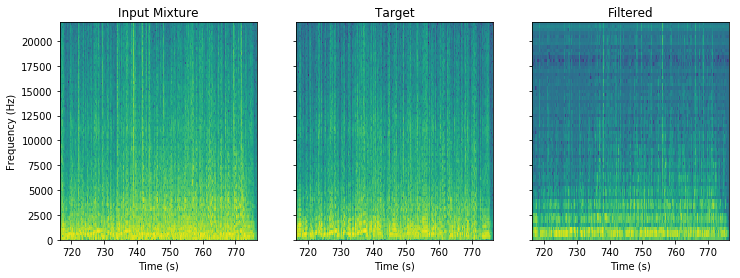

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Filtered")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [26]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)
_, target_audio = signal.istft(target, fs=sample_rate)
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

wavfile.write("fcn_model_2_instrument_prediction.wav", sample_rate, predicted_audio.astype(np.int16))
wavfile.write("fcn_model_2_instrument_target.wav", sample_rate, target_audio.astype(np.int16))
wavfile.write("fcn_model_2_original.wav", sample_rate, mix_audio.astype(np.int16))